### Pre-installations:

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import CSVLogger

# building model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models

# evaluation
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# we use this library in order to get the classes straight from folders without having
# to manually iterate through them



# FLAVIA DATASET

## Pre-processing the data

In [3]:
# get the data
# we will test with the flavia dataset first
all_data_dir=r'S:\Research Project 2022\Flavia_Leaves'
split_data_dir=r"S:\Research Project 2022\SplittedData_1"

Splitting the data into 80/10/10 train/ validation test split by splitting the original data (ONLY RUN THIS ONCE, HOWEVER SINCE THE DATA GIVEN FOR THE RESEARCH IS ALREADY SPLIT BY THIS CODE, DOES NOT NEED TO BE RUN AT ALL)

In [93]:
import splitfolders 

input_folder = all_data_dir

output_folder= split_data_dir

splitfolders.ratio(input_folder, output= output_folder, seed=1337, ratio = (0.8, 0.1, 0.1))

Copying files: 1907 files [00:04, 456.32 files/s]


Here we will be extracting the data from the folders and making them into a datatype that keras can work with. The data will have a 80:10:10 split for training, test, and validation.

We will first train a model without any rotation or transformations to the data and thereafter try to improve this model by applying transformations and then transfer learning.

In [21]:
testDir=r"S:\Research Project 2022\SplittedData_1\test"
trainDir=r"S:\Research Project 2022\SplittedData_1\train"
validDir=r"S:\Research Project 2022\SplittedData_1\val"

I have set the weights to be consistent by setting the seed to be 47

In [125]:
# ensure weights are always the same
np.random.seed(47)
tf.random.set_seed(47)

The following is the baseline model that will be used for a few of the sections. Unless the model has less or more layers, this model will be used throughout.

In [23]:
# define baseline model
def baseline_model():

    model=models.Sequential()

    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3), activation='relu', input_shape=(150,150,3)))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3), activation='relu', input_shape=(150,150,3)))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation='relu'))

    model.add(layers.Dense(32, activation='softmax'))
    model.summary()
    
    return model



The code below are reused multiple times thus are better to be contained in functions. They are mainly for plotting and data visualisation purposes.

In [24]:
def plotConfusionMatrix(labels,predictions): 

    cm = confusion_matrix(labels, predictions)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_gen.class_indices.keys()))

    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')

    plt.show()



In [25]:
def plotGraph(history, titleName):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2.5)
    plt.title(titleName)
    plt.show()

The code below is for testing the models. Due to constant re-use, it was made into a function.

In [26]:
def testModel(model, test_gen, filePath, titleName, totBatchNo):
    batch_num=0
    predictions = np.array([])
    labels =  np.array([])
    print('Batch=', end='')

    # ===============================================================
    # GET TEST MODEL PREDICTIONS
    # ===============================================================
    # loop through the test set
    for x, y in test_gen:
        predictions = np.concatenate([predictions, np.argmax(model.predict(x,verbose = 0), axis = -1)])
        labels = np.concatenate([labels, np.argmax(y, axis=-1)])
        batch_num+=1
        print(batch_num,end='...')

        # ensure we don't repeat the samples when checking accuracy and stop at the right batch 
        if (batch_num>totBatchNo):
            break

    # a check that the batch_num was correct
    try:
        assert len(predictions)== len(labels)
    except AssertionError as e:
        print(e)
    # =============================================================
    # GET ACCURACY PER CLASS
    # =============================================================

    # get the confusion matrix in order to calculate the accuracy per class
    tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
    cm = confusion_matrix(labels, predictions)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm.diagonal()
    acc_each_class = cm.diagonal()

    print('\nAccuracy of each class: \n')


    # =============================================================
    # WRITE TO TEXT FILE 
    # =============================================================

    with open(filePath, 'w') as f:
        f.write(titleName+str(accuracy_score(labels, predictions))+'\n\n\nAccuracy per class:\n\n')
        for i in range(len(list(valid_gen.class_indices.keys()))):
            print(list(test_gen.class_indices.keys())[i], ' : ', acc_each_class[i])
            f.write('\n'+str(list(valid_gen.class_indices.keys())[i])+ ' : '+ str(acc_each_class[i]))
    print('\n')
    print('Test accuracy:',accuracy_score(labels, predictions))
    return labels, predictions

    

## 1. TEST/TRAIN/VALID

This model only contains RGB features. 

DATA
______

1. The log of train accuracy, train loss, validation accuracy, validation loss can be found in [this log file](./Flavia_Results/1.%20rgb%20results/train_test_valid.log) 

2. The last model can be loaded from [this model file](./Flavia_Results/1.%20rgb%20results/Best_train_test_validation.h5) 

3. The test results for the last model can be found in [this text file](./Flavia_Results/1.%20rgb%20results/RGB.txt) 

4. The best model can be loaded from [this model file](./Flavia_Results/1.%20rgb%20results/RGB_Best_Model.txt) 

5. The results for the best model can be found in [this text file](./Flavia_Results/1.%20rgb%20results/RGB_Best_Model.txt) 


In [3]:
# only rescaling the data
all_data_gen=ImageDataGenerator(rescale=1./155)

img_height=150
img_width= 150
batch_size=2
train_gen=all_data_gen.flow_from_directory(trainDir,target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
valid_gen=all_data_gen.flow_from_directory(validDir,target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_gen=all_data_gen.flow_from_directory(testDir,target_size=(img_height, img_width), batch_size=5, class_mode='categorical')


Found 1514 images belonging to 32 classes.
Found 178 images belonging to 32 classes.
Found 215 images belonging to 32 classes.


In [8]:
model=baseline_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [9]:
# save the best model only
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
checkpt=keras.callbacks.ModelCheckpoint("./Flavia_Results/1. rgb results/Best_train_test_validation.h5", monitor='val_loss',save_best_only=True)
csv_logger = CSVLogger('./Flavia_Results/1. rgb results/train_test_valid.log', separator=',', append=True)

In [10]:
history=model.fit(train_gen, steps_per_epoch=757, epochs=45, validation_data=valid_gen, validation_steps=89, callbacks=[csv_logger, checkpt, earlyStopping])

Epoch 1/45
757/757 [==============================] - 103s 130ms/step - loss: 2.1568 - accuracy: 0.3864 - val_loss: 1.0431 - val_accuracy: 0.6573
Epoch 2/45
757/757 [==============================] - 86s 114ms/step - loss: 0.7767 - accuracy: 0.7503 - val_loss: 0.6994 - val_accuracy: 0.7809
Epoch 3/45
757/757 [==============================] - 86s 114ms/step - loss: 0.4523 - accuracy: 0.8547 - val_loss: 0.5046 - val_accuracy: 0.8427
Epoch 4/45
757/757 [==============================] - 80s 106ms/step - loss: 0.2951 - accuracy: 0.9069 - val_loss: 0.3543 - val_accuracy: 0.8876
Epoch 5/45
757/757 [==============================] - 84s 111ms/step - loss: 0.2418 - accuracy: 0.9128 - val_loss: 0.3685 - val_accuracy: 0.8764
Epoch 6/45
757/757 [==============================] - 79s 104ms/step - loss: 0.1879 - accuracy: 0.9425 - val_loss: 0.2812 - val_accuracy: 0.9213
Epoch 7/45
757/757 [==============================] - 89s 118ms/step - loss: 0.0767 - accuracy: 0.9736 - val_loss: 0.3711 - val_a

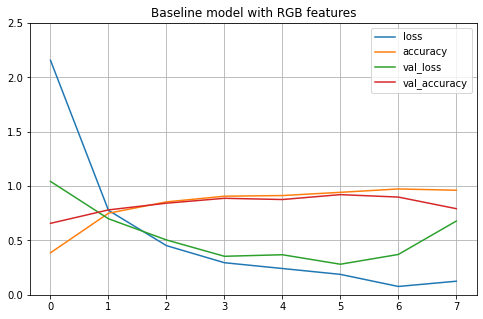

In [12]:
plotGraph(history, "Baseline model with RGB features")

TESTING THE MODEL

In [22]:
labels, predictions=testModel(model, test_gen, "./Flavia_Results/1. rgb results/RGB.txt", "TEST RESULTS:\n\nRGB Test accuracy:", 42)

Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...
Accuracy of each class: 

Anhui Barberry  :  0.5714285714285714
Beale's barberry  :  1.0
Big-fruited Holly  :  1.0
Camphortree  :  0.5714285714285714
Canadian poplar  :  1.0
Castor aralia  :  1.0
Chinese Toon  :  0.8571428571428571
Chinese cinnamon  :  0.8
Chinese horse chestnut  :  1.0
Chinese redbud  :  1.0
Chinese tulip tree  :  1.0
Crepe myrtle  :  1.0
Deodar  :  1.0
Ford Woodlotus  :  0.42857142857142855
Glossy Privet  :  0.875
Goldenrain tree  :  0.6666666666666666
Japan Arrowwood  :  1.0
Japanese Flowering Cherry  :  0.5
Japanese Maple  :  1.0
Japanese cheesewood  :  1.0
Nanmu  :  1.0
Oleander  :  1.0
Peach  :  1.0
Pubescent bamboo  :  1.0
Southern magnolia  :  0.9090909090909091
Sweet osmanthus  :  0.6
Tangerine  :  1.0
Trident maple  :  1.0
True indigo  :  0.666666666

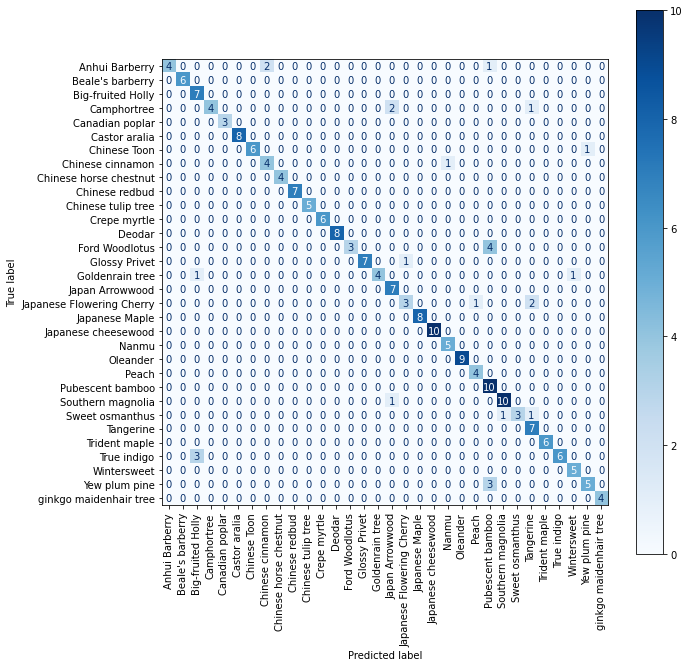

In [23]:
plotConfusionMatrix(labels,predictions)

In [24]:
# save model
model.save("./Flavia_Results/models/Model_Train_Test_Valid.h5")

In [25]:
# CLEAR THE SESSION TO START A NEW ONE
K.clear_session()
del model

In [26]:
#  ================================================
#  USING THE BEST MODEL
#  ================================================

model = keras.models.load_model('./Flavia_Results/1. rgb results/Best_train_test_validation.h5')


labels, predictions=testModel(model, test_gen, './Flavia_Results/1. rgb results/RGB_Best_Model.txt', 'TEST RESULTS:\n\nRGB Test accuracy:', 42)


Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...
Accuracy of each class: 

Anhui Barberry  :  1.0
Beale's barberry  :  1.0
Big-fruited Holly  :  1.0
Camphortree  :  0.7142857142857143
Canadian poplar  :  0.7142857142857143
Castor aralia  :  1.0
Chinese Toon  :  0.8
Chinese cinnamon  :  0.7142857142857143
Chinese horse chestnut  :  0.875
Chinese redbud  :  1.0
Chinese tulip tree  :  1.0
Crepe myrtle  :  1.0
Deodar  :  1.0
Ford Woodlotus  :  1.0
Glossy Privet  :  1.0
Goldenrain tree  :  1.0
Japan Arrowwood  :  1.0
Japanese Flowering Cherry  :  1.0
Japanese Maple  :  1.0
Japanese cheesewood  :  1.0
Nanmu  :  1.0
Oleander  :  1.0
Peach  :  0.6
Pubescent bamboo  :  1.0
Southern magnolia  :  1.0
Sweet osmanthus  :  1.0
Tangerine  :  0.7777777777777778
Trident maple  :  1.0
True indigo  :  1.0
Wintersweet  :  1.0
Yew plum pine  :  

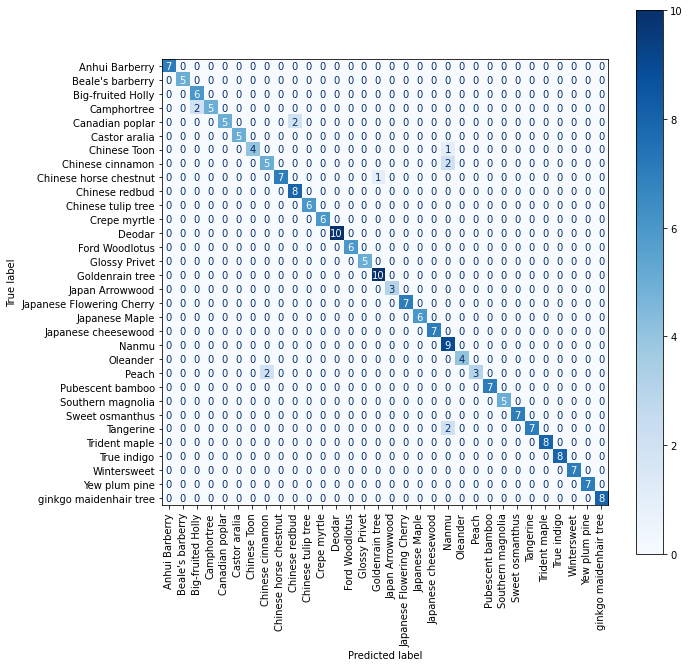

In [27]:
plotConfusionMatrix(labels,predictions)

In [28]:
# CLEAR THE SESSION TO START A NEW ONE
K.clear_session()
del model

# 2. MODEL THAT IS ROTATIONALLY INVARIANT

In this model, we will still use the baseline model, however the imagedatagenerator will now be creating rotationally invariant features. 

DATA
______

1. The log of train accuracy, train loss, validation accuracy, validation loss can be found in [this log file](./Flavia_Results/2.%20rgb_rotation%20results/train_test_valid_rotation.log) 

2. The last model can be loaded from [this model file](./Flavia_Results/2.%20rgb_rotation%20results/model_rgb_rot.h5) 

3. The test results for the last model can be found in [this text file](./Flavia_Results/2.%20rgb_rotation%20results/RGB%20rot.txt) 

4. The best model can be loaded from [this model file](./Flavia_Results/2.%20rgb_rotation%20results/Best_train_test_validation_rotation.h5) 

5. The results for the best model can be found in [this text file](./Flavia_Results/2.%20rgb_rotation%20results/RGB_rot_best.txt) 





In [72]:
# ImageDataGenerator rotation
rot_data_gen=ImageDataGenerator(rescale=1./155,rotation_range=10, fill_mode='nearest')
# ImageDataGenerator no rotation for the test and validation set
all_data_gen=ImageDataGenerator(rescale=1./155)

# we rescale our rgb values to float values

img_height=150
img_width= 150
batch_size=2
train_gen=rot_data_gen.flow_from_directory(trainDir,target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
valid_gen=all_data_gen.flow_from_directory(validDir,target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_gen=all_data_gen.flow_from_directory(testDir,target_size=(img_height, img_width), batch_size=5, class_mode='categorical')


Found 1514 images belonging to 32 classes.
Found 178 images belonging to 32 classes.
Found 215 images belonging to 32 classes.


In [73]:
model=baseline_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [74]:
# save the best model only
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
checkpt=keras.callbacks.ModelCheckpoint("./Flavia_Results/2. rgb_rotation results/Best_train_test_validation_rotation.h5", monitor='val_loss', save_best_only=True)
csv_logger = CSVLogger('./Flavia_Results/2. rgb_rotation results/train_test_valid_rotation.log', separator=',', append=True)

In [75]:
history=model.fit(train_gen, steps_per_epoch=757, epochs=45, validation_data=valid_gen, validation_steps=89, callbacks=[csv_logger, earlyStopping,checkpt])

Epoch 1/45
757/757 [==============================] - 100s 131ms/step - loss: 2.6036 - accuracy: 0.2622 - val_loss: 1.1601 - val_accuracy: 0.6461
Epoch 2/45
757/757 [==============================] - 93s 123ms/step - loss: 1.0555 - accuracy: 0.6777 - val_loss: 0.8144 - val_accuracy: 0.7360
Epoch 3/45
757/757 [==============================] - 102s 135ms/step - loss: 0.6408 - accuracy: 0.8005 - val_loss: 0.5808 - val_accuracy: 0.8090
Epoch 4/45
757/757 [==============================] - 105s 139ms/step - loss: 0.4242 - accuracy: 0.8527 - val_loss: 0.4599 - val_accuracy: 0.8371
Epoch 5/45
757/757 [==============================] - 107s 142ms/step - loss: 0.3582 - accuracy: 0.8752 - val_loss: 0.5614 - val_accuracy: 0.8371
Epoch 6/45
757/757 [==============================] - 115s 152ms/step - loss: 0.2648 - accuracy: 0.9055 - val_loss: 0.4131 - val_accuracy: 0.8708
Epoch 7/45
757/757 [==============================] - 107s 141ms/step - loss: 0.2553 - accuracy: 0.9181 - val_loss: 0.3441 - 

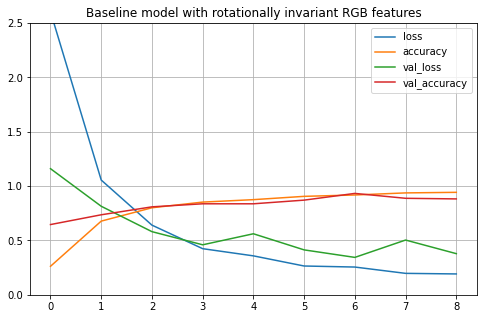

In [76]:
plotGraph(history, 'Baseline model with rotationally invariant RGB features')

In [77]:

labels, predictions=testModel(model, test_gen, './Flavia_Results/2. rgb_rotation results/RGB_rot.txt', 'TEST RESULTS:\n\nRGB Rotational Features Test accuracy:', 42)
  

Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...
Accuracy of each class: 

Anhui Barberry  :  1.0
Beale's barberry  :  0.8333333333333334
Big-fruited Holly  :  0.6
Camphortree  :  0.8571428571428571
Canadian poplar  :  1.0
Castor aralia  :  1.0
Chinese Toon  :  1.0
Chinese cinnamon  :  1.0
Chinese horse chestnut  :  0.8571428571428571
Chinese redbud  :  1.0
Chinese tulip tree  :  1.0
Crepe myrtle  :  1.0
Deodar  :  1.0
Ford Woodlotus  :  1.0
Glossy Privet  :  0.16666666666666666
Goldenrain tree  :  1.0
Japan Arrowwood  :  1.0
Japanese Flowering Cherry  :  0.8333333333333334
Japanese Maple  :  1.0
Japanese cheesewood  :  0.7142857142857143
Nanmu  :  1.0
Oleander  :  1.0
Peach  :  0.16666666666666666
Pubescent bamboo  :  1.0
Southern magnolia  :  1.0
Sweet osmanthus  :  1.0
Tangerine  :  0.8571428571428571
Trident maple  :  1.

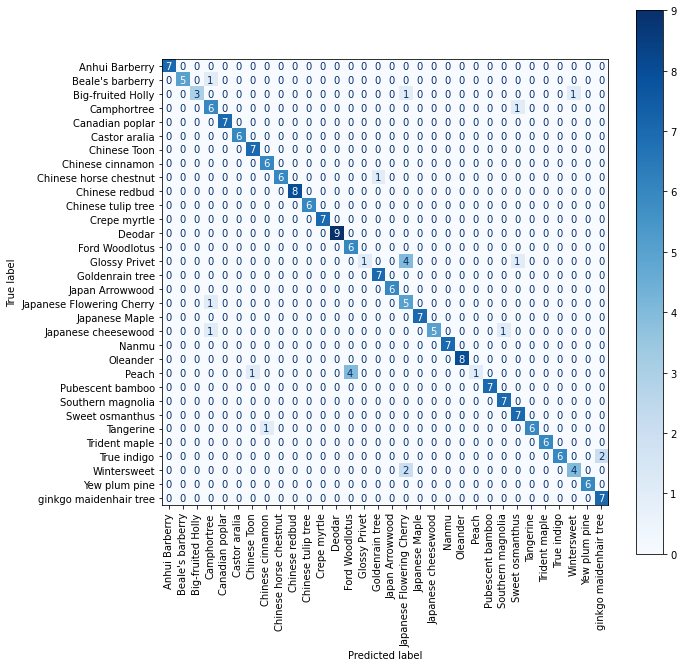

In [78]:
plotConfusionMatrix(labels,predictions)

In [79]:
model.save("./Flavia_Results/2. rgb_rotation results/model_rgb_rot.h5")

In [80]:

K.clear_session()
del model

Testing the best model

In [81]:
#  ================================================
#  USING THE BEST MODEL
#  ================================================

model = keras.models.load_model(r'.\Flavia_Results\2. rgb_rotation results\Best_train_test_validation_rotation.h5')

labels, predictions=testModel(model, test_gen, './Flavia_Results/2. rgb_rotation results/RGB_rot_best.txt', 'TEST RESULTS:\n\nRGB Best Rotational Feature Test accuracy:', 42)


Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...
Accuracy of each class: 

Anhui Barberry  :  0.8571428571428571
Beale's barberry  :  0.8333333333333334
Big-fruited Holly  :  0.4
Camphortree  :  1.0
Canadian poplar  :  1.0
Castor aralia  :  1.0
Chinese Toon  :  1.0
Chinese cinnamon  :  0.8333333333333334
Chinese horse chestnut  :  0.7142857142857143
Chinese redbud  :  1.0
Chinese tulip tree  :  0.8333333333333334
Crepe myrtle  :  1.0
Deodar  :  1.0
Ford Woodlotus  :  0.8333333333333334
Glossy Privet  :  1.0
Goldenrain tree  :  1.0
Japan Arrowwood  :  1.0
Japanese Flowering Cherry  :  0.8333333333333334
Japanese Maple  :  1.0
Japanese cheesewood  :  1.0
Nanmu  :  1.0
Oleander  :  1.0
Peach  :  0.16666666666666666
Pubescent bamboo  :  1.0
Southern magnolia  :  1.0
Sweet osmanthus  :  0.8571428571428571
Tangerine  :  0.71428571

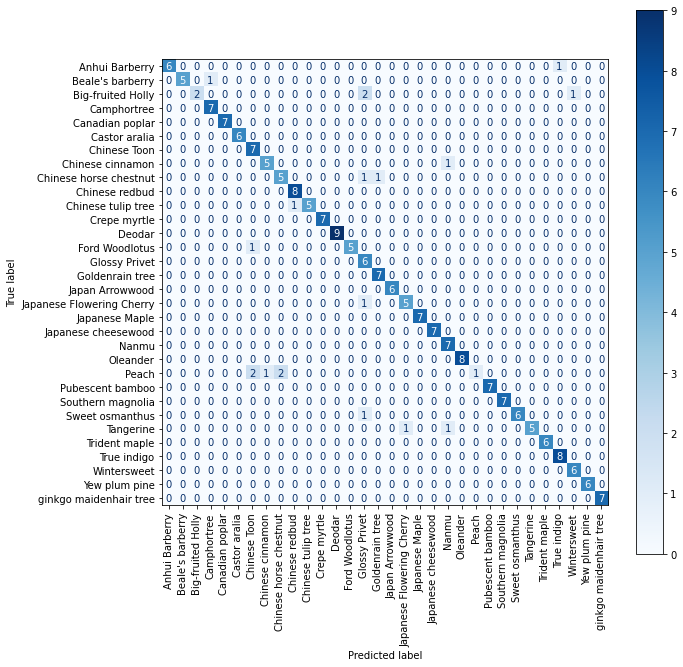

In [82]:
plotConfusionMatrix(labels,predictions)

In [83]:

K.clear_session()
del model

## 3. MODEL THAT IS TRANSLATION INVARIANT

The features have transformations augmented into them.

DATA
______

1. The log of train accuracy, train loss, validation accuracy, validation loss can be found in [this log file](./Flavia_Results/3.%20rgb%20translation/train_test_valid_translation.log) 

2. The last model can be loaded from [this model file](./Flavia_Results/3.%20rgb%20translation/model_rgb_trans.h5) 

3. The test results for the last model can be found in [this text file](./Flavia_Results/3.%20rgb%20translation/RGB_trans.txt) 

4. The best model can be loaded from [this model file](./Flavia_Results/3.%20rgb%20translation/Best_train_test_validation_translation.h5)

5. The results for the best model can be found in [this text file](./Flavia_Results/3.%20rgb%20translation/RGB_trans_Best_Model.txt) 

In [7]:
# ImageDataGenerator translation
trans_data_gen=ImageDataGenerator(rescale=1./155,width_shift_range=0.05, height_shift_range=0.05)

# keep test and validation normal
all_data_gen=ImageDataGenerator(rescale=1./155)

# we rescale our rgb values to float values

img_height=150
img_width= 150
batch_size=2
train_gen=trans_data_gen.flow_from_directory(trainDir,target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
valid_gen=all_data_gen.flow_from_directory(validDir,target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_gen=all_data_gen.flow_from_directory(testDir,target_size=(img_height, img_width), batch_size=5, class_mode='categorical')


Found 1514 images belonging to 32 classes.
Found 178 images belonging to 32 classes.
Found 215 images belonging to 32 classes.


In [8]:
# model=baseline_model()
model=baseline_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [9]:
# save the best model only
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpt=keras.callbacks.ModelCheckpoint("./Flavia_Results/3. rgb translation//Best_train_test_validation_translation.h5", monitor='val_loss', save_best_only=True)
csv_logger = CSVLogger('./Flavia_Results/3. rgb translation/train_test_valid_translation.log', separator=',', append=True)

In [10]:
history=model.fit(train_gen, steps_per_epoch=757, epochs=45, validation_data=valid_gen, validation_steps=89, callbacks=[csv_logger, earlyStopping,checkpt])

Epoch 1/45
757/757 [==============================] - 91s 119ms/step - loss: 2.7172 - accuracy: 0.2431 - val_loss: 1.5636 - val_accuracy: 0.5337
Epoch 2/45
757/757 [==============================] - 83s 110ms/step - loss: 1.1735 - accuracy: 0.6413 - val_loss: 0.6518 - val_accuracy: 0.7978
Epoch 3/45
757/757 [==============================] - 69s 91ms/step - loss: 0.7532 - accuracy: 0.7688 - val_loss: 0.4782 - val_accuracy: 0.8371
Epoch 4/45
757/757 [==============================] - 69s 92ms/step - loss: 0.4933 - accuracy: 0.8250 - val_loss: 0.4219 - val_accuracy: 0.8596
Epoch 5/45
757/757 [==============================] - 69s 91ms/step - loss: 0.3638 - accuracy: 0.8785 - val_loss: 0.4226 - val_accuracy: 0.8820
Epoch 6/45
757/757 [==============================] - 74s 97ms/step - loss: 0.3321 - accuracy: 0.9009 - val_loss: 0.3887 - val_accuracy: 0.8652
Epoch 7/45
757/757 [==============================] - 71s 93ms/step - loss: 0.2378 - accuracy: 0.9161 - val_loss: 0.3582 - val_accurac

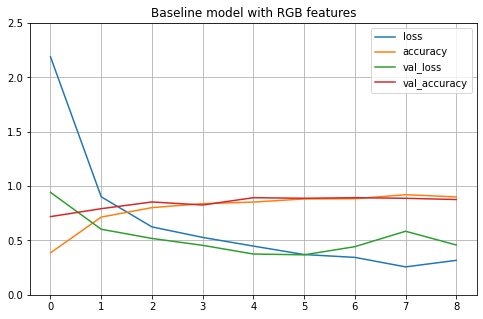

In [121]:
plotGraph(history, 'Baseline model with translation invariant RGB features')

In [13]:
 
labels, predictions=testModel(model, test_gen, './Flavia_Results/3. rgb translation/RGB_trans.txt', 'TEST RESULTS:\n\nRGB Translation Invariant Features Test accuracy:', 42)
  
  

Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...
Accuracy of each class: 

Anhui Barberry  :  1.0
Beale's barberry  :  0.8333333333333334
Big-fruited Holly  :  1.0
Camphortree  :  0.8571428571428571
Canadian poplar  :  1.0
Castor aralia  :  1.0
Chinese Toon  :  0.7142857142857143
Chinese cinnamon  :  0.6666666666666666
Chinese horse chestnut  :  0.8571428571428571
Chinese redbud  :  1.0
Chinese tulip tree  :  1.0
Crepe myrtle  :  1.0
Deodar  :  1.0
Ford Woodlotus  :  0.8333333333333334
Glossy Privet  :  1.0
Goldenrain tree  :  1.0
Japan Arrowwood  :  0.8333333333333334
Japanese Flowering Cherry  :  1.0
Japanese Maple  :  1.0
Japanese cheesewood  :  1.0
Nanmu  :  1.0
Oleander  :  1.0
Peach  :  1.0
Pubescent bamboo  :  1.0
Southern magnolia  :  1.0
Sweet osmanthus  :  0.8571428571428571
Tangerine  :  0.8571428571428571
Trident

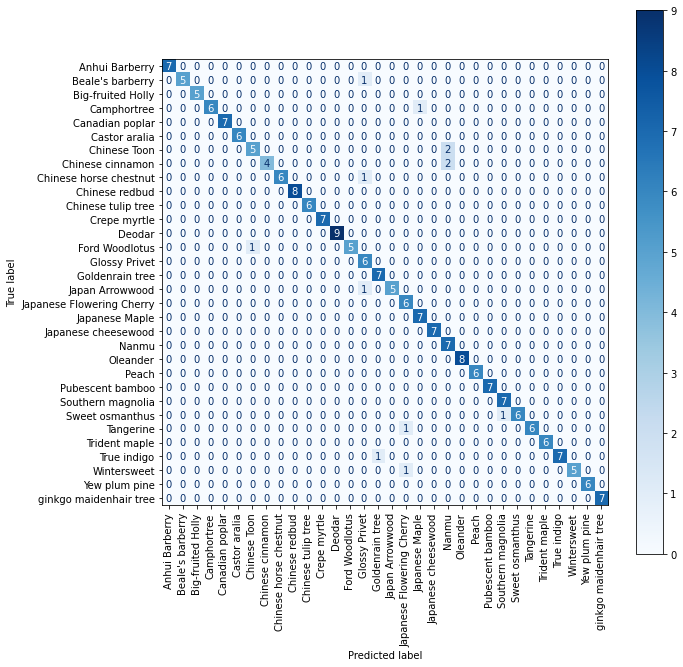

In [14]:
plotConfusionMatrix(labels,predictions)

In [15]:
model.save("./Flavia_Results/3. rgb translation/model_rgb_trans.h5")

In [16]:

K.clear_session()
del model

In [17]:

#  ================================================
#  USING THE BEST MODEL
#  ================================================

model = keras.models.load_model('./Flavia_Results/3. rgb translation/Best_train_test_validation_translation.h5')

labels, predictions=testModel(model, test_gen, './Flavia_Results/3. rgb translation/RGB_trans_Best_Model.txt', 'TEST RESULTS:\n\nRGB Best Translation Invariance Feature Test accuracy:', 42)


  

Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...
Accuracy of each class: 

Anhui Barberry  :  1.0
Beale's barberry  :  1.0
Big-fruited Holly  :  1.0
Camphortree  :  0.7142857142857143
Canadian poplar  :  1.0
Castor aralia  :  1.0
Chinese Toon  :  1.0
Chinese cinnamon  :  1.0
Chinese horse chestnut  :  0.8571428571428571
Chinese redbud  :  0.875
Chinese tulip tree  :  1.0
Crepe myrtle  :  1.0
Deodar  :  1.0
Ford Woodlotus  :  1.0
Glossy Privet  :  1.0
Goldenrain tree  :  1.0
Japan Arrowwood  :  1.0
Japanese Flowering Cherry  :  0.3333333333333333
Japanese Maple  :  0.8571428571428571
Japanese cheesewood  :  0.8571428571428571
Nanmu  :  1.0
Oleander  :  1.0
Peach  :  1.0
Pubescent bamboo  :  1.0
Southern magnolia  :  1.0
Sweet osmanthus  :  1.0
Tangerine  :  0.8571428571428571
Trident maple  :  1.0
True indigo  :  1.0
Wintersw

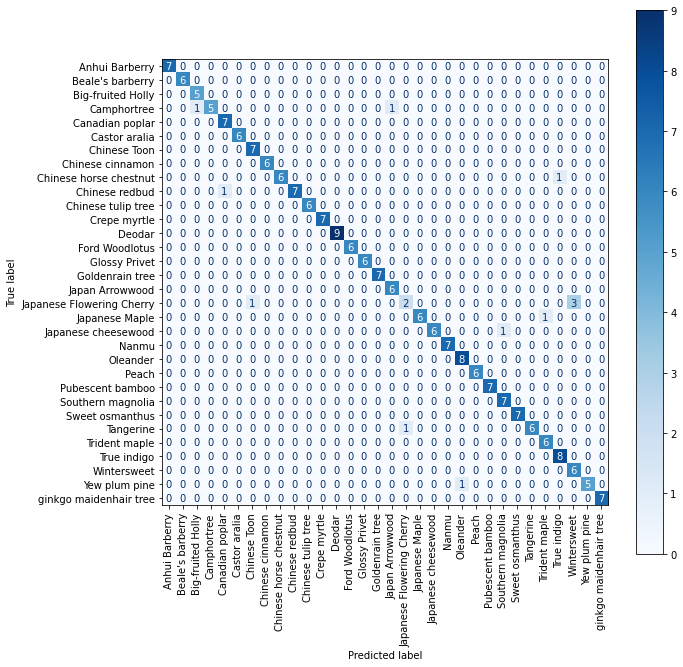

In [18]:
plotConfusionMatrix(labels,predictions)

In [19]:

K.clear_session()
del model

## 4. MODEL THAT IS SCALE INVARIANT




The features have zooms (in and out) augmented into them to create scale invariance.

DATA
______

1. The log of train accuracy, train loss, validation accuracy, validation loss can be found in [this log file](./Flavia_Results/4.%20rgb%20scale%20invariance/rgb_scale.log) 

2. The last model can be loaded from [this model file](./Flavia_Results/4.%20rgb%20scale%20invariance/rgb_scale_model.h5) 

3. The test results for the last model can be found in [this text file](./Flavia_Results/4.%20rgb%20scale%20invariance/rgb_scale_results.txt) 

4. The best model can be loaded from [this model file](./Flavia_Results/4.%20rgb%20scale%20invariance/RGB_scale_best_model_results.txt)

5. The results for the best model can be found in [this text file](./Flavia_Results/4.%20rgb%20scale%20invariance/RGB_scale_best_model_results.txt)

In [45]:
# ImageDataGenerator translation
trans_data_gen=ImageDataGenerator(rescale=1./155,zoom_range=[0.9,1.1])

# keep test and validation normal
all_data_gen=ImageDataGenerator(rescale=1./155)

# we rescale our rgb values to float values

img_height=150
img_width= 150
batch_size=2
train_gen=trans_data_gen.flow_from_directory(trainDir,target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
valid_gen=all_data_gen.flow_from_directory(validDir,target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_gen=all_data_gen.flow_from_directory(testDir,target_size=(img_height, img_width), batch_size=5, class_mode='categorical')


Found 1514 images belonging to 32 classes.
Found 178 images belonging to 32 classes.
Found 215 images belonging to 32 classes.


In [46]:
# model=baseline_model()
model=baseline_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [47]:
# save the best model only
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpt=keras.callbacks.ModelCheckpoint("./Flavia_Results/4. rgb scale invariance/best_rgb_scale.h5", monitor='val_loss', save_best_only=True)
csv_logger = CSVLogger('./Flavia_Results/4. rgb scale invariance/rgb_scale.log', separator=',', append=True)

In [48]:
history=model.fit(train_gen, steps_per_epoch=757, epochs=45, validation_data=valid_gen, validation_steps=89, callbacks=[csv_logger, earlyStopping,checkpt])

Epoch 1/45
757/757 [==============================] - 82s 106ms/step - loss: 2.3814 - accuracy: 0.3395 - val_loss: 0.9917 - val_accuracy: 0.7079
Epoch 2/45
757/757 [==============================] - 82s 109ms/step - loss: 0.8680 - accuracy: 0.7213 - val_loss: 0.8668 - val_accuracy: 0.7303
Epoch 3/45
757/757 [==============================] - 86s 113ms/step - loss: 0.5840 - accuracy: 0.8065 - val_loss: 0.7175 - val_accuracy: 0.7584
Epoch 4/45
757/757 [==============================] - 97s 128ms/step - loss: 0.4584 - accuracy: 0.8520 - val_loss: 0.3283 - val_accuracy: 0.8764
Epoch 5/45
757/757 [==============================] - 94s 124ms/step - loss: 0.3174 - accuracy: 0.8930 - val_loss: 0.3772 - val_accuracy: 0.8989
Epoch 6/45
757/757 [==============================] - 97s 128ms/step - loss: 0.2826 - accuracy: 0.9055 - val_loss: 0.4702 - val_accuracy: 0.8539
Epoch 7/45
757/757 [==============================] - 101s 133ms/step - loss: 0.2790 - accuracy: 0.9135 - val_loss: 0.3951 - val_a

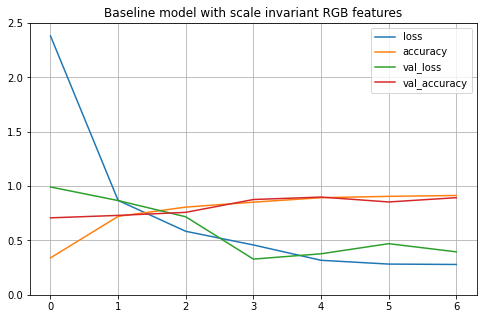

In [49]:
plotGraph(history, 'Baseline model with scale invariant RGB features')

In [50]:
 
labels, predictions=testModel(model, test_gen, './Flavia_Results/4. rgb scale invariance/rgb_scale_results.txt', 'TEST RESULTS:\n\nRGB Scale Invariant Features Test accuracy:', 42)
  
  

Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...
Accuracy of each class: 

Anhui Barberry  :  0.8571428571428571
Beale's barberry  :  1.0
Big-fruited Holly  :  0.6
Camphortree  :  0.8571428571428571
Canadian poplar  :  0.7142857142857143
Castor aralia  :  1.0
Chinese Toon  :  0.8571428571428571
Chinese cinnamon  :  0.8333333333333334
Chinese horse chestnut  :  0.8571428571428571
Chinese redbud  :  1.0
Chinese tulip tree  :  1.0
Crepe myrtle  :  1.0
Deodar  :  1.0
Ford Woodlotus  :  0.8333333333333334
Glossy Privet  :  1.0
Goldenrain tree  :  0.8571428571428571
Japan Arrowwood  :  1.0
Japanese Flowering Cherry  :  0.8333333333333334
Japanese Maple  :  1.0
Japanese cheesewood  :  1.0
Nanmu  :  1.0
Oleander  :  1.0
Peach  :  0.6666666666666666
Pubescent bamboo  :  1.0
Southern magnolia  :  1.0
Sweet osmanthus  :  0.857142857142

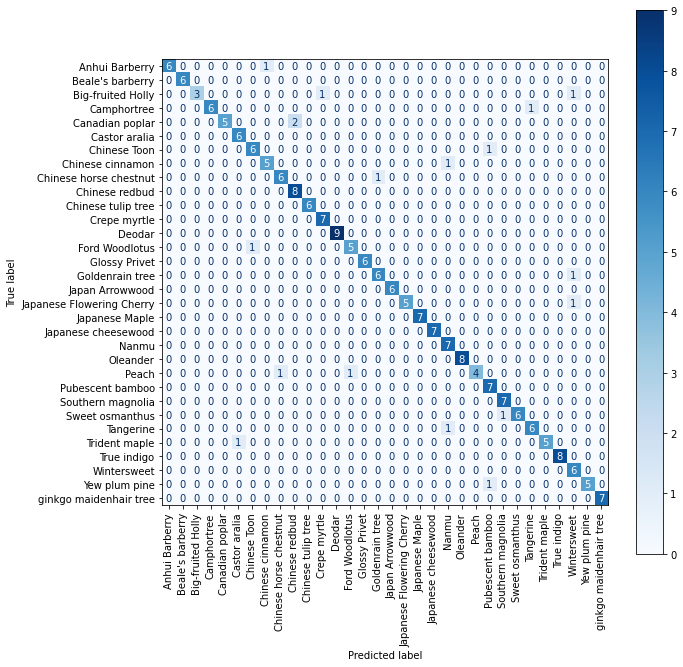

In [51]:
plotConfusionMatrix(labels,predictions)

In [52]:
model.save("./Flavia_Results/4. rgb scale invariance/rgb_scale_model.h5")

In [53]:

K.clear_session()
del model

In [54]:

#  ================================================
#  USING THE BEST MODEL
#  ================================================

model = keras.models.load_model('./Flavia_Results/4. rgb scale invariance/best_rgb_scale.h5')

labels, predictions=testModel(model, test_gen, './Flavia_Results/4. rgb scale invariance/RGB_scale_best_model_results.txt', 'TEST RESULTS:\n\nRGB Best Scale Invariance Feature Test accuracy:', 42)


  

Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...
Accuracy of each class: 

Anhui Barberry  :  0.7142857142857143
Beale's barberry  :  1.0
Big-fruited Holly  :  1.0
Camphortree  :  1.0
Canadian poplar  :  1.0
Castor aralia  :  1.0
Chinese Toon  :  0.7142857142857143
Chinese cinnamon  :  0.6666666666666666
Chinese horse chestnut  :  0.8571428571428571
Chinese redbud  :  1.0
Chinese tulip tree  :  1.0
Crepe myrtle  :  1.0
Deodar  :  1.0
Ford Woodlotus  :  0.8333333333333334
Glossy Privet  :  0.8333333333333334
Goldenrain tree  :  1.0
Japan Arrowwood  :  1.0
Japanese Flowering Cherry  :  0.3333333333333333
Japanese Maple  :  1.0
Japanese cheesewood  :  1.0
Nanmu  :  1.0
Oleander  :  1.0
Peach  :  0.8333333333333334
Pubescent bamboo  :  1.0
Southern magnolia  :  1.0
Sweet osmanthus  :  0.8571428571428571
Tangerine  :  1.0
Trident

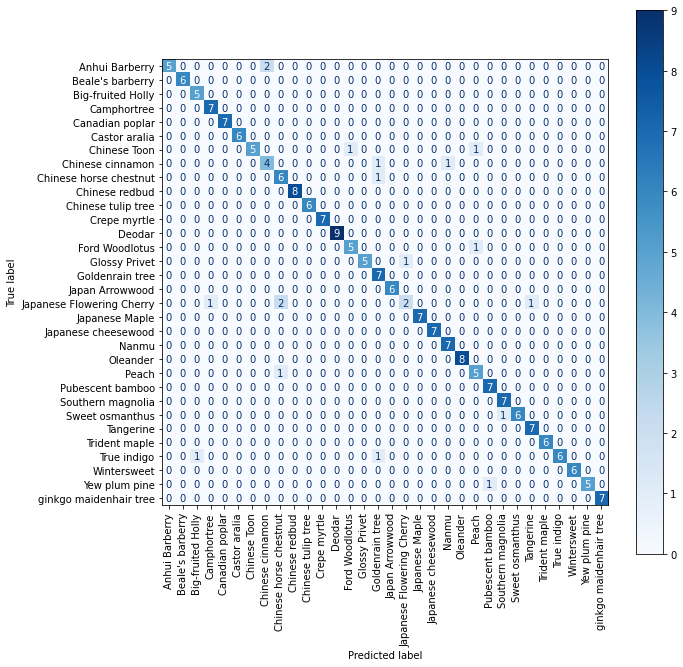

In [55]:
plotConfusionMatrix(labels,predictions)

In [56]:

K.clear_session()
del model

## 5. MODEL THAT IS COMBINATION OF BEST INVARIANT FEATURES


The features have transformations and rotations augmented into them. It appears the scale invariance performed poorly as all leaves were of the same scale.

DATA
______

1. The log of train accuracy, train loss, validation accuracy, validation loss can be found in [this log file](./Flavia_Results/5.%20rgb%20all%20invariance/all_inv_results.log) 

2. The last model can be loaded from [this model file](./Flavia_Results/5.%20rgb%20all%20invariance/all_inv_model_rgb.h5) 

3. The test results for the last model can be found in [this text file](./Flavia_Results/5.%20rgb%20all%20invariance/rgb_all_inv_results.txt) 

4. The best model can be loaded from [this model file](./Flavia_Results/5.%20rgb%20all%20invariance/all_inv_best.h5)

5. The results for the best model can be found in [this text file](./Flavia_Results/5.%20rgb%20all%20invariance/rgb_all_inv_best_results.txt) 

In [84]:
# ImageDataGenerator translation
trans_data_gen=ImageDataGenerator(rescale=1./155,width_shift_range=0.05, height_shift_range=0.05,rotation_range=10, fill_mode='nearest', zoom_range=[0.9,1.1])

# keep test and validation normal
all_data_gen=ImageDataGenerator(rescale=1./155)

# we rescale our rgb values to float values

img_height=150
img_width= 150
batch_size=2
train_gen=trans_data_gen.flow_from_directory(trainDir,target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
valid_gen=all_data_gen.flow_from_directory(validDir,target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_gen=all_data_gen.flow_from_directory(testDir,target_size=(img_height, img_width), batch_size=5, class_mode='categorical')


Found 1514 images belonging to 32 classes.
Found 178 images belonging to 32 classes.
Found 215 images belonging to 32 classes.


In [85]:
# model=baseline_model()
model=baseline_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [86]:
# save the best model only
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpt=keras.callbacks.ModelCheckpoint("./Flavia_Results/5. rgb all invariance/all_inv_best.h5", monitor='val_loss', save_best_only=True)
csv_logger = CSVLogger('./Flavia_Results/5. rgb all invariance/all_inv_results.log', separator=',', append=True)

In [87]:
history=model.fit(train_gen, steps_per_epoch=757, epochs=45, validation_data=valid_gen, validation_steps=89, callbacks=[csv_logger, earlyStopping,checkpt])

Epoch 1/45
757/757 [==============================] - 115s 150ms/step - loss: 3.3449 - accuracy: 0.0819 - val_loss: 2.7402 - val_accuracy: 0.1854
Epoch 2/45
757/757 [==============================] - 102s 134ms/step - loss: 1.6012 - accuracy: 0.5330 - val_loss: 0.8395 - val_accuracy: 0.7697
Epoch 3/45
757/757 [==============================] - 102s 135ms/step - loss: 0.8828 - accuracy: 0.7246 - val_loss: 0.8631 - val_accuracy: 0.7528
Epoch 4/45
757/757 [==============================] - 103s 136ms/step - loss: 0.6563 - accuracy: 0.7801 - val_loss: 0.7501 - val_accuracy: 0.7865
Epoch 5/45
757/757 [==============================] - 100s 132ms/step - loss: 0.5774 - accuracy: 0.8104 - val_loss: 0.6091 - val_accuracy: 0.8090
Epoch 6/45
757/757 [==============================] - 101s 133ms/step - loss: 0.4656 - accuracy: 0.8567 - val_loss: 0.3286 - val_accuracy: 0.8876
Epoch 7/45
757/757 [==============================] - 100s 133ms/step - loss: 0.3819 - accuracy: 0.8752 - val_loss: 0.2793 -

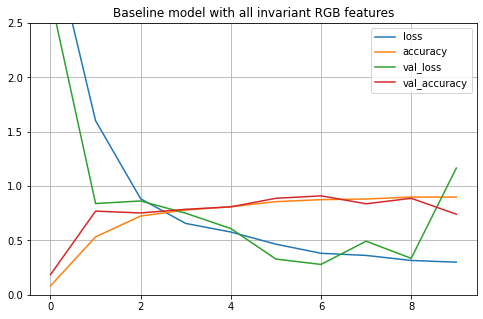

In [88]:
plotGraph(history, 'Baseline model with all invariant RGB features')

In [89]:

labels, predictions=testModel(model, test_gen, './Flavia_Results/5. rgb all invariance/rgb_all_inv_results.txt', 'TEST RESULTS:\n\nRGB All Invariance Features Test accuracy:', 42)
  

Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...
Accuracy of each class: 

Anhui Barberry  :  1.0
Beale's barberry  :  1.0
Big-fruited Holly  :  0.2
Camphortree  :  0.42857142857142855
Canadian poplar  :  0.7142857142857143
Castor aralia  :  1.0
Chinese Toon  :  0.42857142857142855
Chinese cinnamon  :  0.8333333333333334
Chinese horse chestnut  :  0.5714285714285714
Chinese redbud  :  0.625
Chinese tulip tree  :  0.8333333333333334
Crepe myrtle  :  1.0
Deodar  :  1.0
Ford Woodlotus  :  0.6666666666666666
Glossy Privet  :  1.0
Goldenrain tree  :  1.0
Japan Arrowwood  :  1.0
Japanese Flowering Cherry  :  0.8333333333333334
Japanese Maple  :  1.0
Japanese cheesewood  :  1.0
Nanmu  :  1.0
Oleander  :  1.0
Peach  :  0.6666666666666666
Pubescent bamboo  :  0.0
Southern magnolia  :  0.7142857142857143
Sweet osmanthus  :  1.0
Tanger

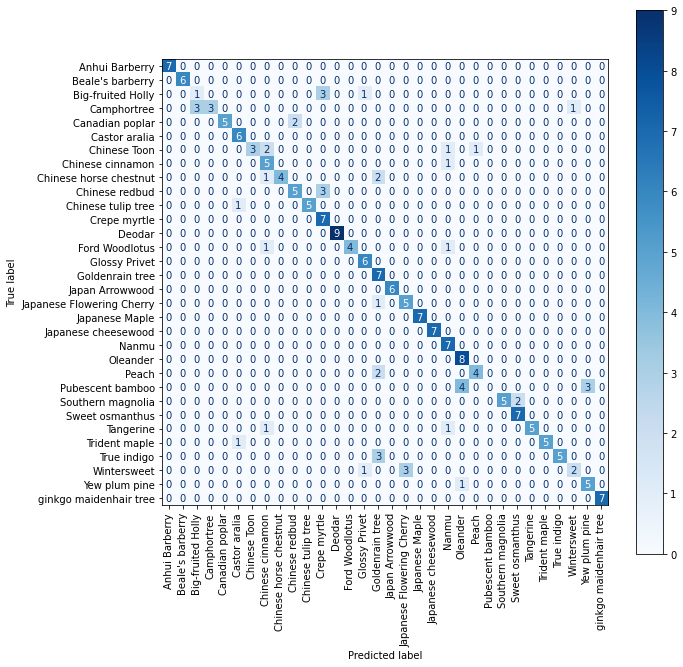

In [90]:
plotConfusionMatrix(labels,predictions)

In [91]:
model.save("./Flavia_Results/5. rgb all invariance/all_inv_model_rgb.h5")

In [92]:

K.clear_session()
del model

In [93]:
#  ================================================
#  USING THE BEST MODEL
#  ================================================

model = keras.models.load_model(r'Flavia_Results\5. rgb all invariance\all_inv_best.h5')

labels, predictions=testModel(model, test_gen, './Flavia_Results/5. rgb all invariance/rgb_all_inv_best_results.txt', 'TEST RESULTS:\n\nRGB Best All invariant Feature Test accuracy:', 42)


Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...
Accuracy of each class: 

Anhui Barberry  :  0.7142857142857143
Beale's barberry  :  1.0
Big-fruited Holly  :  0.2
Camphortree  :  0.7142857142857143
Canadian poplar  :  0.7142857142857143
Castor aralia  :  1.0
Chinese Toon  :  0.8571428571428571
Chinese cinnamon  :  0.6666666666666666
Chinese horse chestnut  :  0.7142857142857143
Chinese redbud  :  1.0
Chinese tulip tree  :  1.0
Crepe myrtle  :  1.0
Deodar  :  1.0
Ford Woodlotus  :  0.8333333333333334
Glossy Privet  :  1.0
Goldenrain tree  :  0.8571428571428571
Japan Arrowwood  :  1.0
Japanese Flowering Cherry  :  0.6666666666666666
Japanese Maple  :  1.0
Japanese cheesewood  :  1.0
Nanmu  :  0.7142857142857143
Oleander  :  1.0
Peach  :  0.6666666666666666
Pubescent bamboo  :  1.0
Southern magnolia  :  1.0
Sweet osmanthus  : 

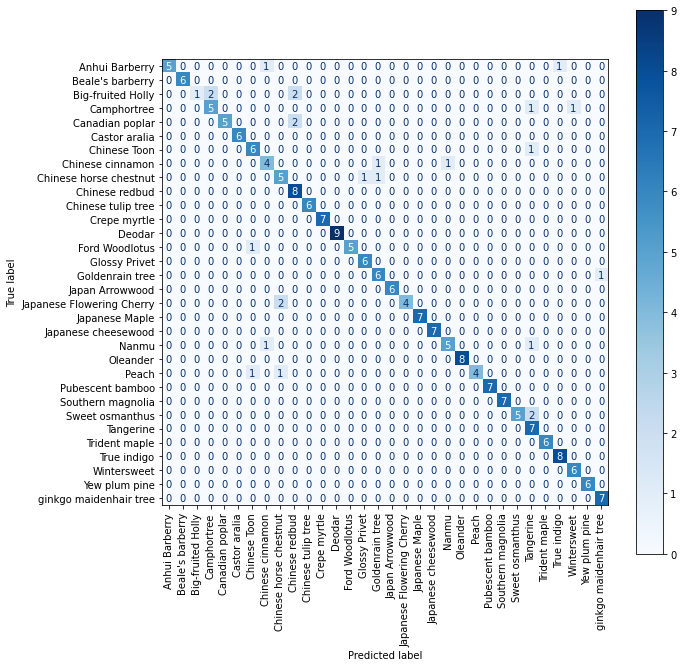

In [94]:
plotConfusionMatrix(labels,predictions)

In [95]:

K.clear_session()
del model

## 6. MODEL THAT MAKES USE OF GRAYSCALE FEATURES

Considering that adding rotational and scalar invariance caused the model to perform worse, only translation invariance is added to this mode. This model uses grayscale features.

DATA
______

1. The log of train accuracy, train loss, validation accuracy, validation loss can be found in [this log file](./Flavia_Results/6.%20grayscale%20all%20invariance/grayscale_results.log) 

2. The last model can be loaded from [this model file](./Flavia_Results/6.%20grayscale%20all%20invariance/gray_model.h5) 

3. The test results for the last model can be found in [this text file](./Flavia_Results/6.%20grayscale%20all%20invariance/gray_model_results.txt) 

4. The best model can be loaded from [this model file](./Flavia_Results/6.%20grayscale%20all%20invariance/best_grayscale.h5) 

5. The results for the best model can be found in [this text file](./Flavia_Results/6.%20grayscale%20all%20invariance/gray_best_results.txt) 


In [137]:
def to_grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    return image

In [138]:
# ImageDataGenerator translation
trans_data_gen=ImageDataGenerator(preprocessing_function = to_grayscale, rescale=1./155,width_shift_range=0.05, height_shift_range=0.05)

# keep test and validation normal
all_data_gen=ImageDataGenerator(preprocessing_function = to_grayscale, rescale=1./155)

# we rescale our rgb values to float values

img_height=150
img_width= 150
batch_size=2
train_gen=trans_data_gen.flow_from_directory(trainDir,target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
valid_gen=all_data_gen.flow_from_directory(validDir,target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_gen=all_data_gen.flow_from_directory(testDir,target_size=(img_height, img_width), batch_size=5, class_mode='categorical')


Found 1514 images belonging to 32 classes.
Found 178 images belonging to 32 classes.
Found 215 images belonging to 32 classes.


In [139]:
model=baseline_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [140]:
# save the best model only
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
checkpt=keras.callbacks.ModelCheckpoint("./Flavia_Results/6. grayscale all invariance/best_grayscale.h5", monitor='val_loss',save_best_only=True)
csv_logger = CSVLogger('./Flavia_Results/6. grayscale all invariance/grayscale_results.log', separator=',', append=True)

In [141]:
history=model.fit(train_gen, steps_per_epoch=757, epochs=45, validation_data=valid_gen, validation_steps=89, callbacks=[csv_logger, checkpt, earlyStopping])

Epoch 1/45
757/757 [==============================] - 79s 104ms/step - loss: 3.1539 - accuracy: 0.1433 - val_loss: 2.0203 - val_accuracy: 0.3933
Epoch 2/45
757/757 [==============================] - 80s 106ms/step - loss: 1.5506 - accuracy: 0.5390 - val_loss: 0.8973 - val_accuracy: 0.7416
Epoch 3/45
757/757 [==============================] - 80s 105ms/step - loss: 0.8840 - accuracy: 0.7272 - val_loss: 0.5555 - val_accuracy: 0.8258
Epoch 4/45
757/757 [==============================] - 82s 108ms/step - loss: 0.6153 - accuracy: 0.8032 - val_loss: 0.3758 - val_accuracy: 0.8596
Epoch 5/45
757/757 [==============================] - 84s 111ms/step - loss: 0.4597 - accuracy: 0.8461 - val_loss: 0.4461 - val_accuracy: 0.8820
Epoch 6/45
757/757 [==============================] - 86s 114ms/step - loss: 0.3742 - accuracy: 0.8765 - val_loss: 0.3903 - val_accuracy: 0.8652


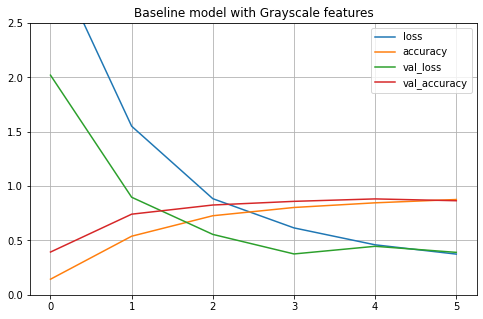

In [142]:
plotGraph(history, "Baseline model with Grayscale features")

In [147]:
labels, predictions=testModel(model, test_gen, "./Flavia_Results/6. grayscale all invariance/gray_model_results.txt", "TEST RESULTS:\n\nGrayscale Test accuracy:", 42)

Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...
Accuracy of each class: 

Anhui Barberry  :  0.8571428571428571
Beale's barberry  :  1.0
Big-fruited Holly  :  1.0
Camphortree  :  0.7142857142857143
Canadian poplar  :  1.0
Castor aralia  :  1.0
Chinese Toon  :  0.7142857142857143
Chinese cinnamon  :  0.16666666666666666
Chinese horse chestnut  :  0.8571428571428571
Chinese redbud  :  0.875
Chinese tulip tree  :  1.0
Crepe myrtle  :  1.0
Deodar  :  1.0
Ford Woodlotus  :  0.8333333333333334
Glossy Privet  :  0.6666666666666666
Goldenrain tree  :  1.0
Japan Arrowwood  :  1.0
Japanese Flowering Cherry  :  0.6666666666666666
Japanese Maple  :  1.0
Japanese cheesewood  :  1.0
Nanmu  :  1.0
Oleander  :  1.0
Peach  :  0.8333333333333334
Pubescent bamboo  :  0.8571428571428571
Southern magnolia  :  1.0
Sweet osmanthus  :  1.0
Tangeri

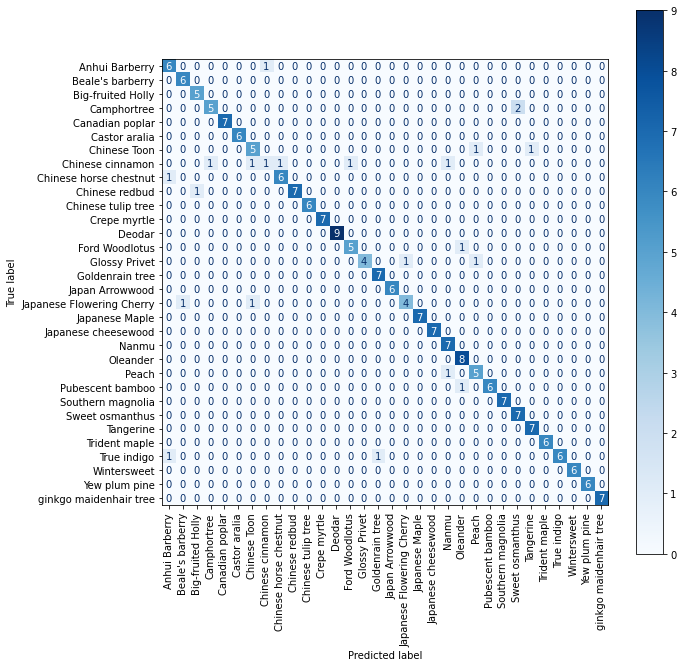

In [148]:
plotConfusionMatrix(labels,predictions)

In [149]:
model.save("./Flavia_Results/6. grayscale all invariance/gray_model.h5")

In [150]:
K.clear_session()
del model

In [151]:
#  ================================================
#  USING THE BEST MODEL
#  ================================================

model = keras.models.load_model(r'.\Flavia_Results\6. grayscale all invariance\best_grayscale.h5')

labels, predictions=testModel(model, test_gen, './Flavia_Results/6. grayscale all invariance/gray_best_results.txt', 'TEST RESULTS:\n\nRGB Best Grayscale Feature Test accuracy:', 42)


Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...
Accuracy of each class: 

Anhui Barberry  :  1.0
Beale's barberry  :  1.0
Big-fruited Holly  :  0.6
Camphortree  :  0.5714285714285714
Canadian poplar  :  1.0
Castor aralia  :  1.0
Chinese Toon  :  0.5714285714285714
Chinese cinnamon  :  0.16666666666666666
Chinese horse chestnut  :  0.8571428571428571
Chinese redbud  :  1.0
Chinese tulip tree  :  1.0
Crepe myrtle  :  1.0
Deodar  :  1.0
Ford Woodlotus  :  1.0
Glossy Privet  :  1.0
Goldenrain tree  :  1.0
Japan Arrowwood  :  1.0
Japanese Flowering Cherry  :  0.8333333333333334
Japanese Maple  :  1.0
Japanese cheesewood  :  1.0
Nanmu  :  1.0
Oleander  :  1.0
Peach  :  0.6666666666666666
Pubescent bamboo  :  1.0
Southern magnolia  :  0.8571428571428571
Sweet osmanthus  :  1.0
Tangerine  :  1.0
Trident maple  :  0.8333333333333334

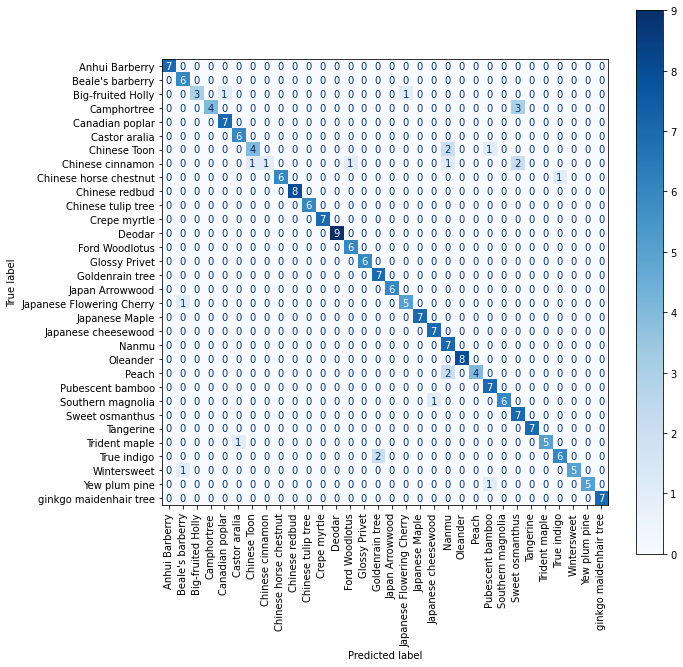

In [152]:
plotConfusionMatrix(labels,predictions)

In [153]:
K.clear_session()
del model

## 7. MODEL THAT MAKES USE OF HSV FEATURES

Considering that combining them resulted in a lower accuracy, we shall only use translation invariance with the HSV features.

DATA
______

1. The log of train accuracy, train loss, validation accuracy, validation loss can be found in [this log file](./Flavia_Results/7.%20hsv%20all%20invariance/hsv_results.log) 

2. The last model can be loaded from [this model file](./Flavia_Results/7.%20hsv%20all%20invariance/hsv_model.h5) 

3. The test results for the last model can be found in [this text file](./Flavia_Results/7.%20hsv%20all%20invariance/hsv_results.txt) 

4. The best model can be loaded from [this model file](./Flavia_Results/7.%20hsv%20all%20invariance/best_hsv_model.h5) 

5. The results for the best model can be found in [this text file](./Flavia_Results/7.%20hsv%20all%20invariance/hsv_best_results.txt) 

In [96]:
import cv2
import numpy as np
from PIL import Image

# preprocessing function for hsv colour space
def convertToHSV(image):
     # turn the image into the HSV space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # # creates a random bright
    # # clips the result between 0 and 255
    # # convert again to uint8
    hsv[:,:,2] =  np.clip(hsv[:,:,2].astype(np.int32) , 0, 255).astype(np.uint8)
    hsv[:,:,0] =  np.clip(hsv[:,:,0].astype(np.int32) , 0, 255).astype(np.uint8)
    hsv[:,:,1] =  np.clip(hsv[:,:,1].astype(np.int32) , 0, 255).astype(np.uint8)

    return hsv

In [126]:
# ImageDataGenerator translation
trans_data_gen=ImageDataGenerator(preprocessing_function = convertToHSV, rescale=1./155,width_shift_range=0.05, height_shift_range=0.05)

# keep test and validation normal
all_data_gen=ImageDataGenerator(preprocessing_function = convertToHSV, rescale=1./155)

# we rescale our rgb values to float values

img_height=150
img_width= 150
batch_size=2
train_gen=trans_data_gen.flow_from_directory(trainDir,target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
valid_gen=all_data_gen.flow_from_directory(validDir,target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_gen=all_data_gen.flow_from_directory(testDir,target_size=(img_height, img_width), batch_size=5, class_mode='categorical')


Found 1514 images belonging to 32 classes.
Found 178 images belonging to 32 classes.
Found 215 images belonging to 32 classes.


In [127]:
model=baseline_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [128]:
# save the best model only
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
checkpt=keras.callbacks.ModelCheckpoint("./Flavia_Results/7. hsv all invariance/best_hsv_model.h5", monitor='val_loss',save_best_only=True)
csv_logger = CSVLogger('./Flavia_Results/7. hsv all invariance/hsv_results.log', separator=',', append=True)

In [129]:
history=model.fit(train_gen, steps_per_epoch=757, epochs=45, validation_data=valid_gen, validation_steps=89, callbacks=[csv_logger, checkpt, earlyStopping])

Epoch 1/45
757/757 [==============================] - 72s 94ms/step - loss: 2.5077 - accuracy: 0.2768 - val_loss: 1.2929 - val_accuracy: 0.6348
Epoch 2/45
757/757 [==============================] - 76s 100ms/step - loss: 1.1487 - accuracy: 0.6387 - val_loss: 0.7037 - val_accuracy: 0.7753
Epoch 3/45
757/757 [==============================] - 77s 102ms/step - loss: 0.7890 - accuracy: 0.7450 - val_loss: 0.4701 - val_accuracy: 0.8315
Epoch 4/45
757/757 [==============================] - 80s 106ms/step - loss: 0.6313 - accuracy: 0.7926 - val_loss: 0.3956 - val_accuracy: 0.8652
Epoch 5/45
757/757 [==============================] - 83s 110ms/step - loss: 0.4953 - accuracy: 0.8322 - val_loss: 0.3498 - val_accuracy: 0.8708
Epoch 6/45
757/757 [==============================] - 84s 111ms/step - loss: 0.4046 - accuracy: 0.8606 - val_loss: 0.3735 - val_accuracy: 0.8933
Epoch 7/45
757/757 [==============================] - 88s 116ms/step - loss: 0.3766 - accuracy: 0.8765 - val_loss: 0.2948 - val_acc

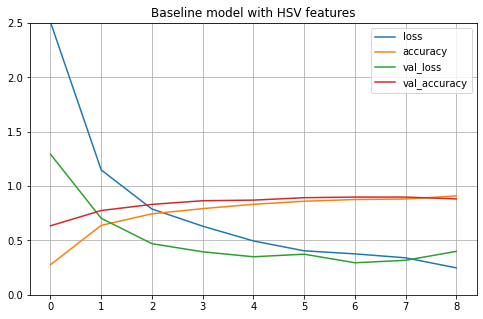

In [130]:
plotGraph(history, "Baseline model with HSV features")

In [131]:
labels, predictions=testModel(model, test_gen, "./Flavia_Results/7. hsv all invariance/hsv_results.txt", "TEST RESULTS:\n\nHSV Test accuracy:", 42)

Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...
Accuracy of each class: 

Anhui Barberry  :  1.0
Beale's barberry  :  0.8333333333333334
Big-fruited Holly  :  1.0
Camphortree  :  0.42857142857142855
Canadian poplar  :  0.5714285714285714
Castor aralia  :  1.0
Chinese Toon  :  1.0
Chinese cinnamon  :  0.6666666666666666
Chinese horse chestnut  :  0.8571428571428571
Chinese redbud  :  1.0
Chinese tulip tree  :  1.0
Crepe myrtle  :  1.0
Deodar  :  1.0
Ford Woodlotus  :  0.8333333333333334
Glossy Privet  :  1.0
Goldenrain tree  :  1.0
Japan Arrowwood  :  1.0
Japanese Flowering Cherry  :  1.0
Japanese Maple  :  1.0
Japanese cheesewood  :  1.0
Nanmu  :  1.0
Oleander  :  1.0
Peach  :  0.3333333333333333
Pubescent bamboo  :  0.8571428571428571
Southern magnolia  :  0.7142857142857143
Sweet osmanthus  :  1.0
Tangerine  :  0.85714285

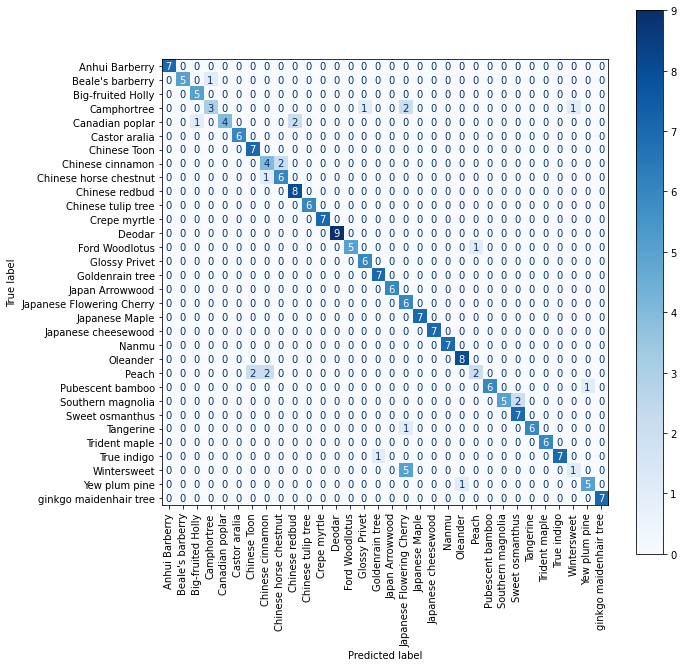

In [132]:
plotConfusionMatrix(labels,predictions)

In [133]:
model.save("./Flavia_Results/7. hsv all invariance/hsv_model.h5")

In [134]:
K.clear_session()
del model

In [135]:
#  ================================================
#  USING THE BEST MODEL
#  ================================================

model = keras.models.load_model(r'.\Flavia_Results\7. hsv all invariance\best_hsv_model.h5')

labels, predictions=testModel(model, test_gen, './Flavia_Results/7. hsv all invariance/hsv_best_results.txt', 'TEST RESULTS:\n\nRGB Best HSV Feature Test accuracy:', 42)


Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...
Accuracy of each class: 

Anhui Barberry  :  0.7142857142857143
Beale's barberry  :  1.0
Big-fruited Holly  :  1.0
Camphortree  :  0.5714285714285714
Canadian poplar  :  1.0
Castor aralia  :  1.0
Chinese Toon  :  0.8571428571428571
Chinese cinnamon  :  0.6666666666666666
Chinese horse chestnut  :  0.8571428571428571
Chinese redbud  :  0.5
Chinese tulip tree  :  1.0
Crepe myrtle  :  1.0
Deodar  :  1.0
Ford Woodlotus  :  1.0
Glossy Privet  :  0.6666666666666666
Goldenrain tree  :  0.7142857142857143
Japan Arrowwood  :  1.0
Japanese Flowering Cherry  :  0.6666666666666666
Japanese Maple  :  1.0
Japanese cheesewood  :  0.8571428571428571
Nanmu  :  1.0
Oleander  :  1.0
Peach  :  0.3333333333333333
Pubescent bamboo  :  1.0
Southern magnolia  :  0.7142857142857143
Sweet osmanthus  : 

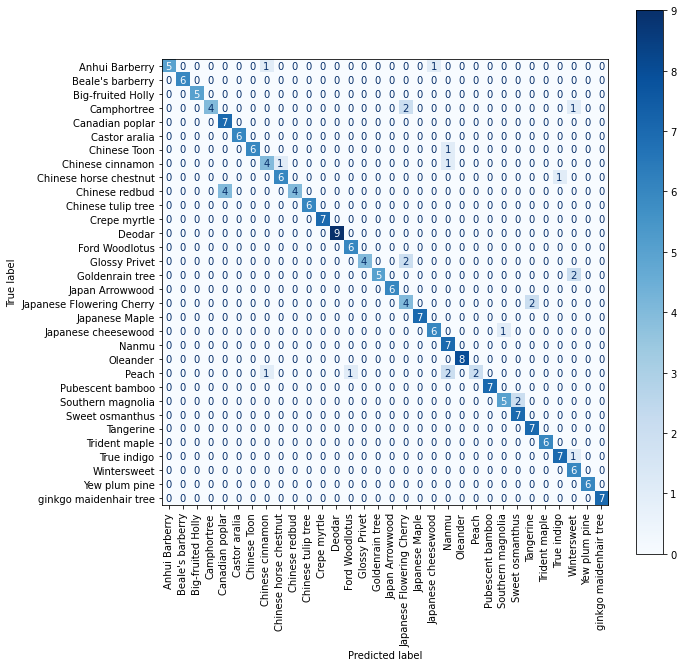

In [136]:
plotConfusionMatrix(labels,predictions)

In [108]:
K.clear_session()
del model